In [ ]:
!pip install  dgl -f https://data.dgl.ai/wheels/torch-2.4/cu124/repo.html --quiet
!pip install torchmetrics==1.4.2 --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 347.8/347.8 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 797.3/797.3 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 126.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 90.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 61.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.2/176.2 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import networkx as nx

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.distributed as dist
import torchmetrics

import os
import argparse
os.environ["DGLBACKEND"] = "pytorch"

import dgl
import dgl.data
from dgl.nn import GATv2Conv, GlobalAttentionPooling
from dgl.dataloading import GraphDataLoader
from dgl.data import DGLDataset

In [ ]:
# Reading a file with node types list . Upload the all_node_types.pkl file .

unpickled_df = pd.read_pickle("/content/all_node_types.pkl")
ar = [str(item) for item in unpickled_df]
instructions = dict(zip(ar, range(1, len(ar)+1)))

In [ ]:
# Reading the dataset .
# Our dataset is in 3 separate files - node.csv , edges.csv , properties.csv
# Upload them

nodes_train = pd.read_csv("/content/nodes_train.csv")
edges_train = pd.read_csv("/content/edges_train.csv")
properties_train = pd.read_csv("/content/properties_train.csv")
nodes_test = pd.read_csv("/content/nodes_test.csv")
edges_test = pd.read_csv("/content/edges_test.csv")
properties_test = pd.read_csv("/content/properties_test.csv")



In [ ]:
class MyUtils(object):
    @staticmethod
    def init_process_group(world_size, rank):
        dist.init_process_group(
            backend="gloo",  # change to 'nccl' for multiple GPUs
            init_method="tcp://127.0.0.1:12345",
            world_size=world_size,
            rank=rank,
        )

    @staticmethod
    def get_feature(batchg):
        return torch.cat(
            (batchg.ndata["instruction_type"],),
            1,
        )

    @staticmethod
    def try_gpu(i=0):
        if i < 0:
            return torch.device("cpu")
        if torch.cuda.device_count() >= i + 1:
            return torch.device(f"cuda:{i}")
        return torch.device("cpu")

    @staticmethod
    def class_weight(train_dataset, device):
        neg, pos = np.bincount(train_dataset.labels.tolist())
        weight = [(1.0 / neg) * (pos + neg) / 2.0, (1.0 / pos) * (pos + neg) / 2.0]
        return torch.FloatTensor(weight).to(device)

    @staticmethod
    def weight_init(m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)

    @staticmethod
    def accuracy(y_hat, y):
        if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
            y_hat = argmax(y_hat, axis=1)
        cmp = astype(y_hat, y.dtype) == y
        return float(reduce_sum(astype(cmp, y.dtype)))

    @staticmethod
    def trainEpoch(net, trainDataLoader, loss, weight, updater, device):
        if isinstance(net, torch.nn.Module):
            net.train()

        metric = MyAccumulator(3)

        for X, y in trainDataLoader:
            X = X.to(device)
            y = y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y, weight=weight)
            updater.zero_grad()
            l.backward()
            updater.step()
            with torch.no_grad():
                metric.add(
                    l * X.batch_size,
                    MyUtils.accuracy(y_hat, y),
                    X.batch_size,
                )
        return metric[0] / metric[2], metric[1] / metric[2]


class MyAccumulator(object):
    """For accumulating sums over `n` variables."""

    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]


reduce_sum = lambda x, *args, **kwargs: x.sum(*args, **kwargs)
argmax = lambda x, *args, **kwargs: x.argmax(*args, **kwargs)
astype = lambda x, *args, **kwargs: x.type(*args, **kwargs)

In [ ]:
# my ------------------------------------------------------------------



import dgl.function as fn
import dgl.nn as dglnn
from dgl.base import DGLError
from dgl.nn.functional import edge_softmax


class WeightedGATConv(dglnn.GATConv):
    """
    This model inherit from dgl GATConv for traffic prediction task,
    it add edge weight when aggregating the node feature.
    """

    def forward(self, graph, feat, get_attention=False):
        with graph.local_scope():
            if not self._allow_zero_in_degree:
                if (graph.in_degrees() == 0).any():
                    raise DGLError(
                        "There are 0-in-degree nodes in the graph, "
                        "output for those nodes will be invalid. "
                        "This is harmful for some applications, "
                        "causing silent performance regression. "
                        "Adding self-loop on the input graph by "
                        "calling `g = dgl.add_self_loop(g)` will resolve "
                        "the issue. Setting ``allow_zero_in_degree`` "
                        "to be `True` when constructing this module will "
                        "suppress the check and let the code run."
                    )

            if isinstance(feat, tuple):
                h_src = self.feat_drop(feat[0])
                h_dst = self.feat_drop(feat[1])
                if not hasattr(self, "fc_src"):
                    feat_src = self.fc(h_src).view(
                        -1, self._num_heads, self._out_feats
                    )
                    feat_dst = self.fc(h_dst).view(
                        -1, self._num_heads, self._out_feats
                    )
                else:
                    feat_src = self.fc_src(h_src).view(
                        -1, self._num_heads, self._out_feats
                    )
                    feat_dst = self.fc_dst(h_dst).view(
                        -1, self._num_heads, self._out_feats
                    )
            else:
                h_src = h_dst = self.feat_drop(feat)
                feat_src = feat_dst = self.fc(h_src).view(
                    -1, self._num_heads, self._out_feats
                )
                if graph.is_block:
                    feat_dst = feat_src[: graph.number_of_dst_nodes()]
            # NOTE: GAT paper uses "first concatenation then linear projection"
            # to compute attention scores, while ours is "first projection then
            # addition", the two approaches are mathematically equivalent:
            # We decompose the weight vector a mentioned in the paper into
            # [a_l || a_r], then
            # a^T [Wh_i || Wh_j] = a_l Wh_i + a_r Wh_j
            # Our implementation is much efficient because we do not need to
            # save [Wh_i || Wh_j] on edges, which is not memory-efficient. Plus,
            # addition could be optimized with DGL's built-in function u_add_v,
            # which further speeds up computation and saves memory footprint.
            el = (feat_src * self.attn_l).sum(dim=-1).unsqueeze(-1)
            er = (feat_dst * self.attn_r).sum(dim=-1).unsqueeze(-1)
            graph.srcdata.update({"ft": feat_src, "el": el})
            graph.dstdata.update({"er": er})
            # compute edge attention, el and er are a_l Wh_i and a_r Wh_j respectively.
            graph.apply_edges(fn.u_add_v("el", "er", "e"))
            e = self.leaky_relu(graph.edata.pop("e"))
            # compute softmax
            graph.edata["a"] = self.attn_drop(edge_softmax(graph, e))
            # compute weighted attention
            graph.edata["a"] = (
                graph.edata["a"].permute(1, 2, 0) * graph.edata["weight"]
            ).permute(2, 0, 1)
            # message passing
            graph.update_all(fn.u_mul_e("ft", "a", "m"), fn.sum("m", "ft"))
            rst = graph.dstdata["ft"]
            # residual
            if self.res_fc is not None:
                resval = self.res_fc(h_dst).view(
                    h_dst.shape[0], -1, self._out_feats
                )
                rst = rst + resval
            # activation
            if self.activation:
                rst = self.activation(rst)

            if get_attention:
                return rst, graph.edata["a"]
            else:
                return rst


class GatedGAT(nn.Module):
    """Gated Graph Attention module, it is a general purpose
    graph attention module proposed in paper GaAN. The paper use
    it for traffic prediction task
    Parameter
    ==========
    in_feats : int
        number of input feature

    out_feats : int
        number of output feature

    map_feats : int
        intermediate feature size for gate computation

    num_heads : int
        number of head for multihead attention
    """

    def __init__(self, in_feats, out_feats, map_feats, num_heads):
        super(GatedGAT, self).__init__()
        self.in_feats = in_feats
        self.out_feats = out_feats
        self.map_feats = map_feats
        self.num_heads = num_heads
        self.gatlayer = WeightedGATConv(
            self.in_feats, self.out_feats, self.num_heads,allow_zero_in_degree=True,residual=True,activation=F.leaky_relu
        )
        self.gate_fn = nn.Linear(
            2 * self.in_feats + self.map_feats, self.num_heads
        )
        self.gate_m = nn.Linear(self.in_feats, self.map_feats)
        self.merger_layer = nn.Linear(
            self.in_feats + self.out_feats, self.out_feats
        )

    def forward(self, g, x):
        #print('dddddd')
        with g.local_scope():
            g.ndata["x"] = x
            g.ndata["z"] = self.gate_m(x)
            g.update_all(fn.copy_u("x", "x"), fn.mean("x", "mean_z"))
            g.update_all(fn.copy_u("z", "z"), fn.max("z", "max_z"))
            nft = torch.cat(
                [g.ndata["x"], g.ndata["max_z"], g.ndata["mean_z"]], dim=1
            )
            gate = self.gate_fn(nft).sigmoid()
            attn_out = self.gatlayer(g, x)
            node_num = g.num_nodes()
            gated_out = (
                (gate.view(-1) * attn_out.view(-1, self.out_feats).T).T
            ).view(node_num, self.num_heads, self.out_feats)
            gated_out = gated_out.mean(1)
            #print(gated_out.shape)
            merge = self.merger_layer(torch.cat([x, gated_out], dim=1))
            #print(merge.shape)
            return merge

In [ ]:
# my -----------------------------------------------------------

import dgl
import dgl.function as fn
import dgl.nn as dglnn
import numpy as np
import scipy.sparse as sparse
import torch
import torch.nn as nn
from dgl.base import DGLError
from dgl.nn.functional import edge_softmax


class GraphGRUCell(nn.Module):
    """Graph GRU unit which can use any message passing
    net to replace the linear layer in the original GRU
    Parameter
    ==========
    in_feats : int
        number of input features

    out_feats : int
        number of output features

    net : torch.nn.Module
        message passing network
    """

    def __init__(self, in_feats, out_feats, net):
        super(GraphGRUCell, self).__init__()
        self.in_feats = in_feats
        self.out_feats = out_feats
        self.dir = dir
        # net can be any GNN model
        self.r_net = net(in_feats + out_feats, out_feats)
        self.u_net = net(in_feats + out_feats, out_feats)
        self.c_net = net(in_feats + out_feats, out_feats)
        # Manually add bias Bias
        self.r_bias = nn.Parameter(torch.rand(out_feats))
        self.u_bias = nn.Parameter(torch.rand(out_feats))
        self.c_bias = nn.Parameter(torch.rand(out_feats))

    def forward(self, g, x, h):
        r = torch.sigmoid(self.r_net(g, torch.cat([x, h], dim=1)) + self.r_bias)
        u = torch.sigmoid(self.u_net(g, torch.cat([x, h], dim=1)) + self.u_bias)
        h_ = r * h
        c = torch.sigmoid(
            self.c_net(g, torch.cat([x, h_], dim=1)) + self.c_bias
        )
        new_h = u * h + (1 - u) * c
        return new_h


class StackedEncoder(nn.Module):
    """One step encoder unit for hidden representation generation
    it can stack multiple vertical layers to increase the depth.

    Parameter
    ==========
    in_feats : int
        number if input features

    out_feats : int
        number of output features

    num_layers : int
        vertical depth of one step encoding unit

    net : torch.nn.Module
        message passing network for graph computation
    """

    def __init__(self, in_feats, out_feats, num_layers, net):
        super(StackedEncoder, self).__init__()
        self.in_feats = in_feats
        self.out_feats = out_feats
        self.num_layers = num_layers
        self.net = net
        self.layers = nn.ModuleList()
        if self.num_layers <= 0:
            raise DGLError("Layer Number must be greater than 0! ")
        self.layers.append(
            GraphGRUCell(self.in_feats, self.out_feats, self.net)
        )
        for _ in range(self.num_layers - 1):
            self.layers.append(
                GraphGRUCell(self.out_feats, self.out_feats, self.net)
            )

    # hidden_states should be a list which for different layer
    def forward(self, g, x, hidden_states):
        hiddens = []
        for i, layer in enumerate(self.layers):
            x = layer(g, x, hidden_states[i])
            hiddens.append(x)
        return x, hiddens


class StackedDecoder(nn.Module):
    """One step decoder unit for hidden representation generation
    it can stack multiple vertical layers to increase the depth.

    Parameter
    ==========
    in_feats : int
        number if input features

    hid_feats : int
        number of feature before the linear output layer

    out_feats : int
        number of output features

    num_layers : int
        vertical depth of one step encoding unit

    net : torch.nn.Module
        message passing network for graph computation
    """

    def __init__(self, in_feats, hid_feats, out_feats, num_layers, net):
        super(StackedDecoder, self).__init__()
        self.in_feats = in_feats
        self.hid_feats = hid_feats
        self.out_feats = out_feats
        self.num_layers = num_layers
        self.net = net
        self.out_layer = nn.Linear(self.hid_feats, self.out_feats)
        self.layers = nn.ModuleList()
        if self.num_layers <= 0:
            raise DGLError("Layer Number must be greater than 0!")
        self.layers.append(GraphGRUCell(self.in_feats, self.hid_feats, net))
        for _ in range(self.num_layers - 1):
            self.layers.append(
                GraphGRUCell(self.hid_feats, self.hid_feats, net)
            )

    def forward(self, g, x, hidden_states):
        hiddens = []
        for i, layer in enumerate(self.layers):
            x = layer(g, x, hidden_states[i])
            hiddens.append(x)
        x = self.out_layer(x)
        return x, hiddens


class GraphRNN(nn.Module):
    """Graph Sequence to sequence prediction framework
    Support multiple backbone GNN. Mainly used for traffic prediction.

    Parameter
    ==========
    in_feats : int
        number of input features

    out_feats : int
        number of prediction output features

    seq_len : int
        input and predicted sequence length

    num_layers : int
        vertical number of layers in encoder and decoder unit

    net : torch.nn.Module
        Message passing GNN as backbone

    decay_steps : int
        number of steps for the teacher forcing probability to decay
    """

    def __init__(
        self, in_feats, out_feats, seq_len, num_layers, net, decay_steps
    ):
        super(GraphRNN, self).__init__()
        self.in_feats = in_feats
        self.out_feats = out_feats
        self.seq_len = seq_len
        self.num_layers = num_layers
        self.net = net
        self.decay_steps = decay_steps

        self.encoder = StackedEncoder(
            self.in_feats, self.out_feats, self.num_layers, self.net
        )

        self.decoder = StackedDecoder(
            self.in_feats,
            self.out_feats,
            self.in_feats,
            self.num_layers,
            self.net,
        )

    # Threshold For Teacher Forcing

    def compute_thresh(self, batch_cnt):
        return self.decay_steps / (
            self.decay_steps + np.exp(batch_cnt / self.decay_steps)
        )

    def encode(self, g, inputs, device):
        hidden_states = [
            torch.zeros(g.num_nodes(), self.out_feats).to(device)
            for _ in range(self.num_layers)
        ]
        for i in range(self.seq_len):
            _, hidden_states = self.encoder(g, inputs[i], hidden_states)

        return hidden_states

    def decode(self, g, teacher_states, hidden_states, batch_cnt, device):
        outputs = []
        inputs = torch.zeros(g.num_nodes(), self.in_feats).to(device)
        for i in range(self.seq_len):
            if (
                np.random.random() < self.compute_thresh(batch_cnt)
                and self.training
            ):
                inputs, hidden_states = self.decoder(
                    g, teacher_states[i], hidden_states
                )
            else:
                inputs, hidden_states = self.decoder(g, inputs, hidden_states)
            outputs.append(inputs)
        outputs = torch.stack(outputs)
        return outputs

    def forward(self, g, inputs, teacher_states, batch_cnt, device):
        hidden = self.encode(g, inputs, device)
        outputs = self.decode(g, teacher_states, hidden, batch_cnt, device)
        return outputs

In [ ]:
class MyGATv2(nn.Module):

    def __init__(
        self,
        h_dim,
        num_classes,
        num_heads,
        feat_dropout,
        attn_dropout,
        layers,
        in_dimN=15,
    ) -> None:
        super(MyGATv2, self).__init__()

        self.convsN = nn.Sequential(
            GatedGAT(
                in_dimN,
                h_dim,1000,
                num_heads=num_heads,
                #feat_drop=feat_dropout,
                #attn_drop=attn_dropout,
                #residual=True,
                #activation=F.relu,
                #allow_zero_in_degree=True,
            )
        )

        for i in range(1, layers):
            self.convsN.add_module(
                str(i),
                GatedGAT(
                    h_dim,
                    h_dim,1000,
                    num_heads=num_heads,
                    #feat_drop=feat_dropout,
                    #attn_drop=attn_dropout,
                    #residual=True,
                    #activation=F.relu,
                    #allow_zero_in_degree=True,
                ),
            )

        self.gPool = GlobalAttentionPooling(nn.Linear(h_dim, 1))
        self.dropout = nn.Dropout(feat_dropout)

        self.linear = nn.Linear(h_dim, 2 * h_dim)
        self.classify = nn.Linear(2 * h_dim, num_classes)

    def forward(self, g):
        hN = MyUtils.get_feature(g)

        hg = None
        for i in range(len(self.convsN)):
            #print(i)
            hNf = F.leaky_relu(self.convsN[i](g, hN).flatten(1))
            #print(hNf.shape, 'hn')
            #print(F.relu(self.convsN[i](g, hN)).shape, 'hn2')
            #print('hddd')
            hN=hNf

            with g.local_scope():
                g.ndata["h"] = hN
                newhN = dgl.softmax_nodes(g, "h")

                if hg == None:
                    hg = self.gPool(g, newhN)
                else:
                    hg = hg + self.gPool(g, newhN)

        return self.classify(F.leaky_relu(self.dropout(self.linear(hg))))

In [ ]:

from functools import partial

class CFGDatasetForPy(DGLDataset):
    def __init__(
        self,
        trainProjectName,
        trainVersion,
        testProjectName,
        testVersion,
        isTraining,
    ):
        self.instruction = instructions
        self.instruction_enc = F.one_hot(torch.arange(len(self.instruction) + 1))

        self.project, self.version = (
            (trainProjectName, trainVersion)
            if isTraining
            else (testProjectName, testVersion)
        )
        super().__init__(name="CFG")

    def process(self):
        if self.project == 'train':
            nodes = nodes_train
            edges = edges_train
            properties = properties_train
        else:
            nodes = nodes_test
            edges = edges_test
            properties = properties_test

        self.graphs = []
        self.labels = []

        label_dict = {}
        num_nodes_dict = {}
        for _, row in properties.iterrows():
            label_dict[row["cfg_id"]] = 1 if row["label"] >= 1 else 0
            num_nodes_dict[row["cfg_id"]] = row["num_nodes"]

        edges_group = edges.groupby("cfg_id")
        nodes_group = nodes.groupby("cfg_id")

        for graph_id in edges_group.groups:
            edges_of_id = edges_group.get_group(graph_id)
            nodes_of_id = nodes_group.get_group(graph_id).sort_values(by="node_id")
            src = edges_of_id["src"].to_numpy()
            dst = edges_of_id["dst"].to_numpy()
            num_nodes = num_nodes_dict[graph_id]
            label = label_dict[graph_id]

            g = dgl.graph((src, dst), num_nodes=num_nodes)

            itList = []
            for iv in nodes_of_id["instruction_type"]:
                itList.append(
                    self.instruction_enc[self.instruction[iv]]
                    if self.instruction[iv]
                    else self.instruction_enc[0]
                )

            g.ndata["instruction_type"] = torch.stack(itList).float()
            g.edata['weight'] = torch.ones(g.num_edges())

            # removing isolated nodes from our graph
            isolated_nodes = ((g.in_degrees() == 0) & (g.out_degrees() == 0)).nonzero().squeeze(1)
            g.remove_nodes(isolated_nodes)

            self.graphs.append(g)
            self.labels.append(label)

        self.labels = torch.LongTensor(self.labels)

    def __getitem__(self, i):
        return self.graphs[i], self.labels[i]

    def __len__(self):
        return len(self.graphs)


def evaluate(net, data_iter, device):
    if isinstance(net, torch.nn.Module):
        net.eval()
    net.to(device)

    y, y_hat = [], []
    labels, preds = [], []

    with torch.no_grad():
        for X, y in data_iter:
            X = X.to(device)
            y = y.to(device)
            y_hat = net(X)

            preds.append(y_hat.argmax(1))
            labels.append(y)

        return (
            torchmetrics.functional.precision(
                torch.cat(preds), torch.cat(labels), "binary"
            ),
            torchmetrics.functional.recall(
                torch.cat(preds), torch.cat(labels), "binary"
            ),
            torchmetrics.functional.fbeta_score(
                torch.cat(preds), torch.cat(labels), "binary", beta=1.0
            ),
            torchmetrics.functional.auroc(
                torch.cat(preds).float(), torch.cat(labels), "binary"
            ),
            torchmetrics.functional.matthews_corrcoef(
                torch.cat(preds).float(), torch.cat(labels), "binary"
            ),
        )


def train(net, train_iter, num_epochs, updater, scheduler, device):
    net.apply(MyUtils.weight_init)
    weight = MyUtils.class_weight(train_iter.dataset, device)
    net.to(device)
    for epoch in range(num_epochs):
        #train_iter.set_epoch(epoch)
        train_loss, train_acc = MyUtils.trainEpoch(
            net,
            train_iter,
            F.cross_entropy,
            weight,
            updater,
            device,
        )
        scheduler.step()
        if epoch % 50 == 0:
            print(
                "Epoch {}: train loss {:.4f}  train acc: {:.5f} \n".format(
                    epoch, train_loss, train_acc
                ),
                flush=True,
            )


def sdpProcess(
    trainProjectName,
    testProjectName,
    trainVersion,
    testVersion,
    device,
    layers,
    hiddens,
    par_epochs,
    par_num_heads,
):

    lr, epochs, batch_size, dropout = (1e-2, par_epochs, 64, 0.4)
    schedulerStepSize, schedulerGamma = 16, 0.9
    hidden_dim, num_heads = hiddens, par_num_heads

    # -------------
    model = MyGATv2(hidden_dim, 2, num_heads, dropout, dropout, layers, 27)

    #model = GatedGAT(in_feats=27, out_feats=2, map_feats=hidden_dim, num_heads=num_heads)


    trainDataset, testDataset = CFGDatasetForPy(
        trainProjectName, trainVersion, testProjectName, testVersion, True
    ), CFGDatasetForPy(
        trainProjectName, trainVersion, testProjectName, testVersion, False
    )

    trainDataloader, testDataloader = GraphDataLoader(
        trainDataset, batch_size=batch_size,drop_last=False,shuffle=True
    ), GraphDataLoader(testDataset, batch_size=batch_size, drop_last=False,shuffle=True)

    optimizer = optim.AdamW(model.parameters(), lr)
    scheduler = torch.optim.lr_scheduler.StepLR(
        optimizer=optimizer, step_size=schedulerStepSize, gamma=schedulerGamma
    )

    print(
        "training start: {}--{}-----{}--{}\n".format(
            trainProjectName, trainVersion, testProjectName, testVersion
        ),
        flush=True,
    )

    train(model, trainDataloader, epochs, optimizer, scheduler, device)

    metric_all = evaluate(model, testDataloader, device)

    print(
        "===========P=============\n{}\n===========R=============\n{}\n===========F1=============\n{}\n===========AUC=============\n{}\n===========MCC=============\n{}\n".format(
            metric_all[0].item(),
            metric_all[1].item(),
            metric_all[2].item(),
            metric_all[3].item(),
            metric_all[4].item(),
        ),
        flush=True,
    )

In [ ]:

for i in range(1):
    sdpProcess(
        'train',
        'test',
        'train',
        'test',
        MyUtils.try_gpu(),
        2,
        128,
        500,
        8,
)

training start: train--train-----test--test

Epoch 0: train loss 1.1101  train acc: 0.52098 

Epoch 50: train loss 0.3708  train acc: 0.79720 

Epoch 100: train loss 0.1749  train acc: 0.91259 

Epoch 150: train loss 0.1232  train acc: 0.93706 

Epoch 200: train loss 0.0764  train acc: 0.95804 

Epoch 250: train loss 0.0792  train acc: 0.96503 

Epoch 300: train loss 0.0609  train acc: 0.97902 

Epoch 350: train loss 0.0623  train acc: 0.96503 

Epoch 400: train loss 0.0467  train acc: 0.97902 

Epoch 450: train loss 0.0436  train acc: 0.97902 

===========P=============
0.9021739363670349
===========R=============
0.8783068656921387
===========F1=============
0.890080451965332
===========AUC=============
0.8463698625564575
===========MCC=============
0.6846647262573242



In [ ]:
trainDataset, testDataset = CFGDatasetForPy(
    "train", "train", "test", "test", True
    ), CFGDatasetForPy(
    "train", "train", "test", "test", False
)

In [ ]:
options = {
    'node_color': 'black',
    'node_size': 20,
    'width': 1,
}
def draw_graph(ind):
  g = trainDataset[ind][0]
  has_bug = trainDataset[ind][1].item()
  print('Label :', has_bug)
  G = dgl.to_networkx(g, node_attrs=['instruction_type'])
  plt.figure(figsize=[8,5])
  labels = nx.get_node_attributes(G, 'instruction_type')
  labels_tmp = [torch.nonzero(labels[i]).item() for i in range(len(labels))]
  labels_inst = [list(instructions.keys())[list(instructions.values()).index(ind)] for ind in labels_tmp]
  nx.draw(G, **options, with_labels = True, labels=dict(zip(range(len(labels_inst)), labels_inst)))

train_labels=[trainDataset[ind][1].item() for ind in range(len(trainDataset))]
test_labels=[testDataset[ind][1].item() for ind in range(len(testDataset))]
print(f'Class ratio in train -    {sum(train_labels)/len(trainDataset):.2f} : {(len(trainDataset)-sum(train_labels))/len(trainDataset):.2f}')
print(f'Class ratio in test -    {sum(test_labels)/len(testDataset):.2f} : {(len(testDataset)-sum(test_labels))/len(testDataset):.2f}')

Class ratio in train -    0.67 : 0.33
Class ratio in test -    0.65 : 0.35


Label : 0


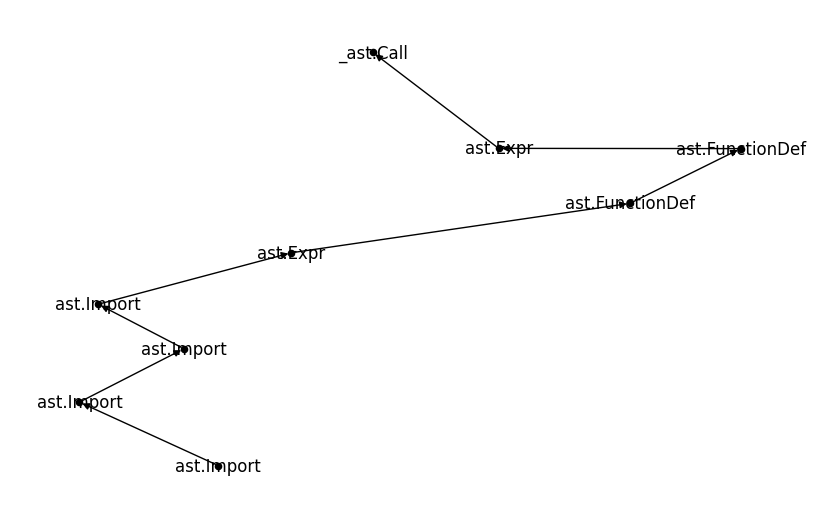

In [ ]:
draw_graph(0)

Label : 1


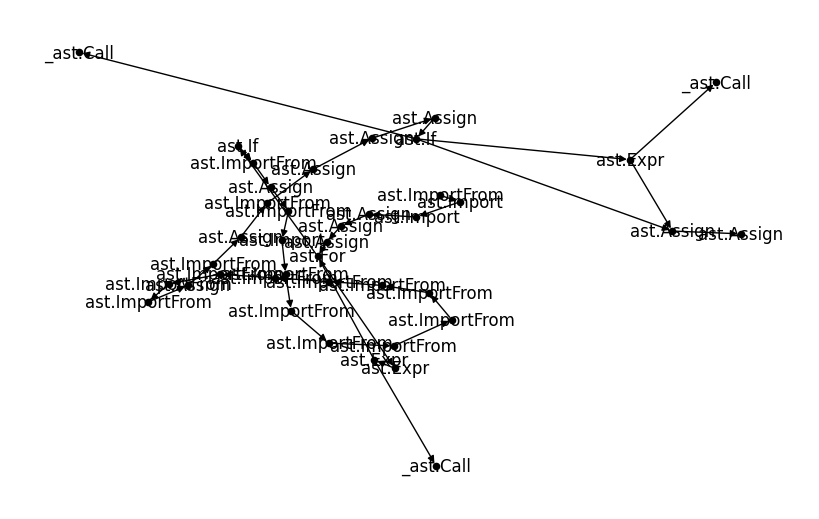

In [ ]:
draw_graph(1)

Label : 1


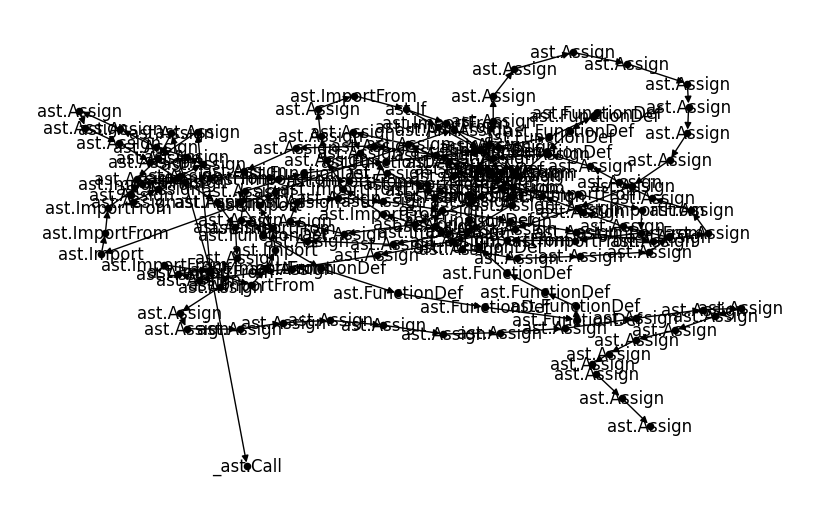

In [ ]:
draw_graph(2)

Label : 1


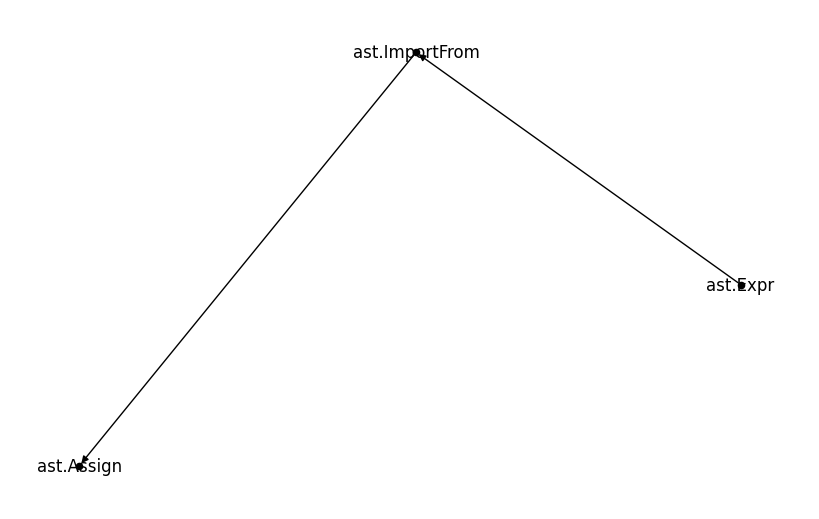

In [ ]:
draw_graph(3)

Label : 0


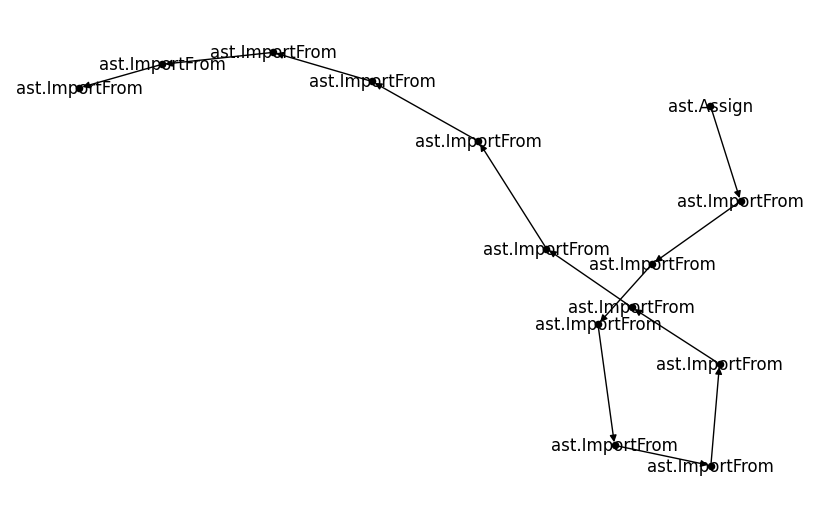

In [ ]:
draw_graph(5)